In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

### 1- Global Variables

In [3]:
####### Variables #####"

IMAGE_SIZE = 256
BATCH_SIZE = 32
RGB_CHANNELS = 3
EPOCHS = 50 #50

### 2- Load Dataset

    "dataset/" is the path to our dataset folder

In [4]:
imageDataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/",
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = imageDataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(imageDataset)

68

### 3- Quick overview of the datas (Images)

In [8]:
for image_batch, label_batch in imageDataset.take(1):
    #print(image_batch.shape)
    #print(label_batch.numpy())
    print(image_batch[0].shape)

(256, 256, 3)


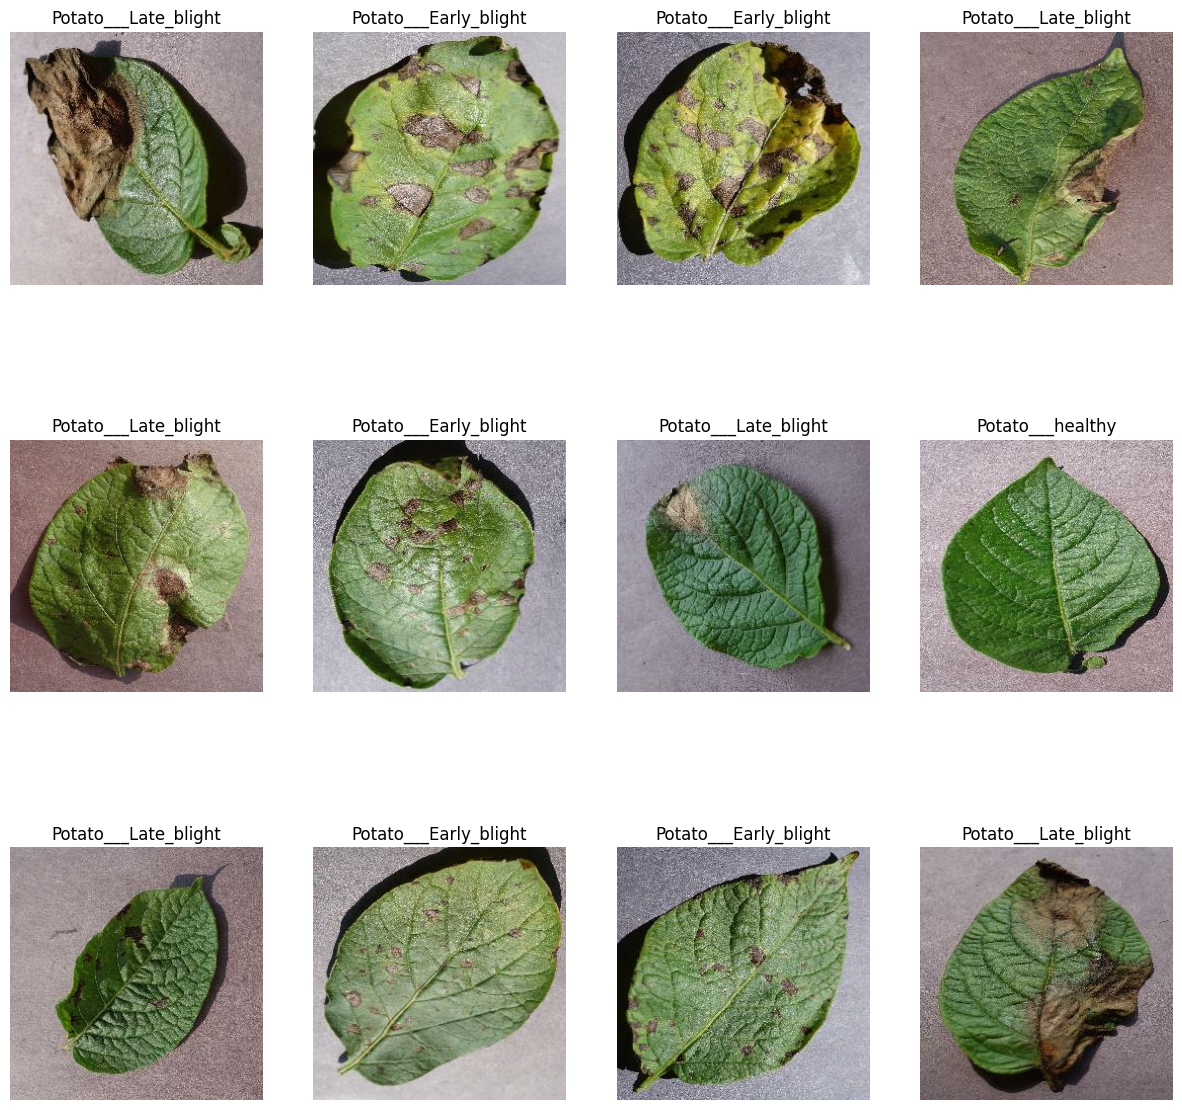

In [9]:
plt.figure(figsize=(15, 15))

for image_batch, label_batch in imageDataset.take(1):
    
    """plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])"""
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### 3- Split our dataset for model Training

- `80%` ==> training
- `20%` ==> 10% validation, 10% test

In [16]:
"""
    This function splits our dataset into : train, validation and test sets
"""
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000 ):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=10)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_set = ds.take(train_size)
    val_set = ds.skip(train_size).take(val_size)
    test_set = ds.skip(train_size).skip(val_size)
    
    return train_set, validation_set, test_set


In [17]:
train_set, validation_set, test_set = get_dataset_partitions_tf(imageDataset)

In [18]:
len(train_set)

54

### 4- Catching and Fetching

    - Read image from disk and put it in cache for next usages ( for memory performance purpose)

In [19]:
# 
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_set = validation_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### 4- Preprocessing

    - Resize the images to the same size

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### 5- Data augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### 6- Build, train the Model : using `CNN Model`

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, RGB_CHANNELS)
nbr_classes = 3

In [23]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(nbr_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

#### - A summary of the model

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

#### - Compile for uptimization

In [25]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics =  ['accuracy']
)

#### - Fit the model

In [26]:
history = model.fit(
    train_set,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validation_set,
)

Epoch 1/50
54/54 [==============================] - 28s 503ms/step - loss: 0.9097 - accuracy: 0.4671 - val_loss: 0.8448 - val_accuracy: 0.5469
Epoch 2/50
54/54 [==============================] - 42s 785ms/step - loss: 0.7673 - accuracy: 0.6461 - val_loss: 0.4900 - val_accuracy: 0.7917
Epoch 3/50
54/54 [==============================] - 46s 847ms/step - loss: 0.5755 - accuracy: 0.7694 - val_loss: 0.3885 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 46s 849ms/step - loss: 0.4174 - accuracy: 0.8257 - val_loss: 0.2254 - val_accuracy: 0.9271
Epoch 5/50
54/54 [==============================] - 46s 848ms/step - loss: 0.2640 - accuracy: 0.8950 - val_loss: 0.1732 - val_accuracy: 0.9427
Epoch 6/50
54/54 [==============================] - 46s 852ms/step - loss: 0.2458 - accuracy: 0.9085 - val_loss: 0.3344 - val_accuracy: 0.8542
Epoch 7/50
54/54 [==============================] - 46s 847ms/step - loss: 0.2306 - accuracy: 0.9102 - val_loss: 0.1159 - val_accuracy: 0.9688

In [27]:
scores = model.evaluate(test_set)

8/8 [==============================] - 2s 138ms/step - loss: 0.0527 - accuracy: 0.9805


In [28]:
scores

[0.052731577306985855, 0.98046875]

In [29]:
 history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
len(history.history['accuracy']) # equal to number of EPOCH

50

In [32]:
accs = history.history['accuracy']
val_accs = history.history['val_accuracy']
losses = history.history['loss']
val_losses = history.history['val_loss']

### 7- Training and Validation Accuracy Plot

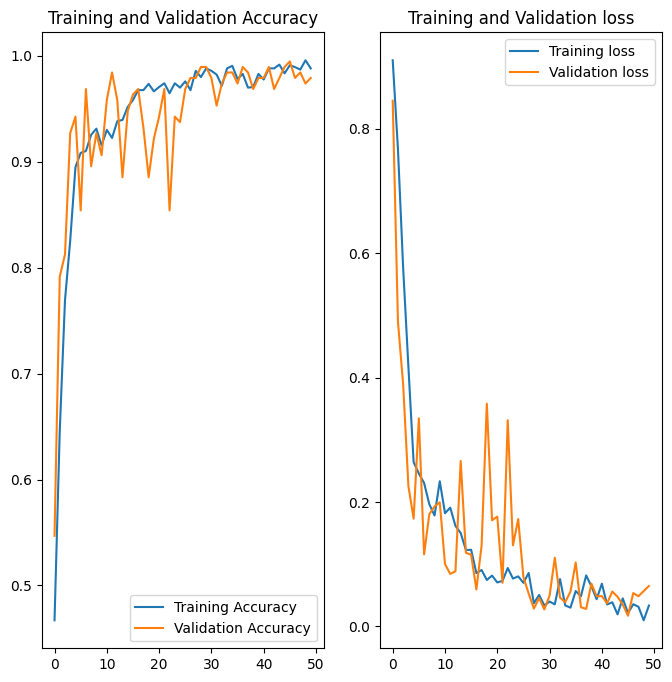

In [36]:

# For accuracy Plot
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accs, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_accs, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# For Training loss Plot

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), losses, label = 'Training loss')
plt.plot(range(EPOCHS), val_losses, label = 'Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 164ms/step
predicted label : Potato___Late_blight


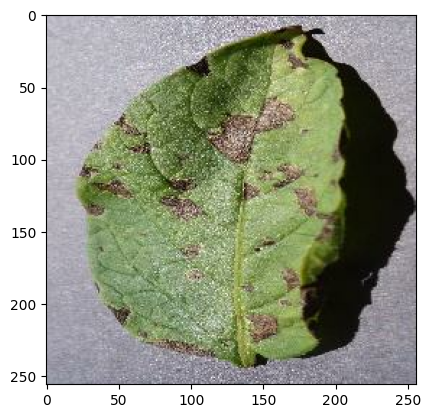

In [39]:
for images_batch, labels_batch in test_set.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
 
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    #print(np.argmax(batch_prediction[0]))

    print('predicted label :', class_names[np.argmax(batch_prediction[0])] )

### 8- Prediction

In [41]:
def predict(model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2 )

    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


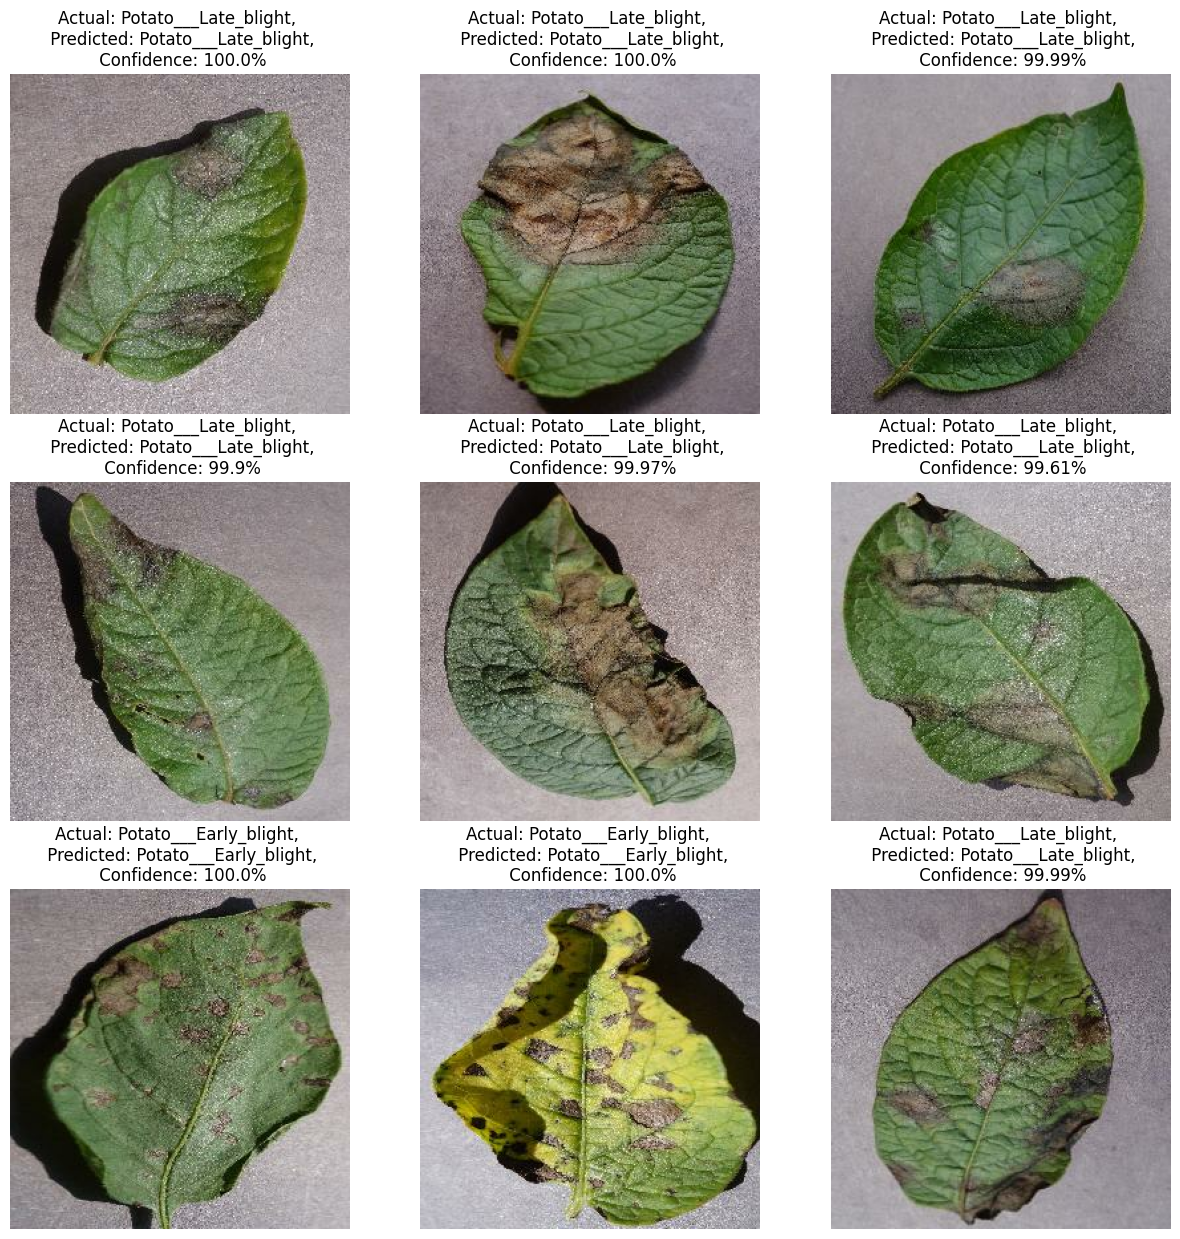

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class},\n Confidence: {confidence}%")
        
        plt.axis('off')
        

### 8- Save the model

In [63]:
import os

model_version = 1 #max([int(i) for i in os.listdir("../models") + [0]])+1

In [64]:
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1/assets


INFO:tensorflow:Assets written to: ../saved_models/1/assets
